# Forecasting 


In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Previous cycle  

______________________________


We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()  
- Prepare data: prepare.prep_store_data()  
- Split data: prepare.split_store_data()  

Then we will forecast and evaluate using each method. 

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# wrangle
import acquire
import prepare

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

## Wrangle


In [3]:
df = acquire.get_store_item_demand_data()
df = prepare.prep_storeitems(df)
df.head()

,item_id,sale_amount,sale_id,store_id,Unnamed: 0_x,store_address,store_city,store_state,store_zipcode,Unnamed: 0_y,item_brand,item_name,item_price,item_upc12,item_upc14,month,day_of_week,sales_total
sale_date,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,41,6.0,730401,1,0,12125 Alamo Ranch Pkwy,San Antonio,TX,78253,0,P.f. Changs,P.f. Changs Home Menu Meal For Two Beef With B...,5.62,31000670016,31000670016,01-Jan,Tuesday,33.72
2013-01-01 00:00:00+00:00,48,21.0,865525,5,4,1520 Austin Hwy,San Antonio,TX,78218,7,Dove,Dove Men + Care Antiperspirant Deodorant Cool ...,3.72,79400271631,79400271631,01-Jan,Tuesday,78.12
2013-01-01 00:00:00+00:00,41,11.0,743183,8,7,15000 San Pedro Ave,San Antonio,TX,78232,0,P.f. Changs,P.f. Changs Home Menu Meal For Two Beef With B...,5.62,31000670016,31000670016,01-Jan,Tuesday,61.82
2013-01-01 00:00:00+00:00,48,34.0,863699,4,3,516 S Flores St,San Antonio,TX,78204,7,Dove,Dove Men + Care Antiperspirant Deodorant Cool ...,3.72,79400271631,79400271631,01-Jan,Tuesday,126.48
2013-01-01 00:00:00+00:00,48,28.0,861873,3,2,2118 Fredericksburg Rdj,San Antonio,TX,78201,7,Dove,Dove Men + Care Antiperspirant Deodorant Cool ...,3.72,79400271631,79400271631,01-Jan,Tuesday,104.16



We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

In [5]:
df_resampled = df.resample('d')[['sale_amount','sales_total']].sum()
df_resampled.head()

,sale_amount,sales_total
sale_date,,
2013-01-01 00:00:00+00:00,2302.0,12715.58
2013-01-02 00:00:00+00:00,2418.0,13315.71
2013-01-03 00:00:00+00:00,2533.0,14120.52
2013-01-04 00:00:00+00:00,2661.0,14860.53
2013-01-05 00:00:00+00:00,2852.0,15645.95


## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiply by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [6]:
df_resampled.shape

(1826, 2)

In [7]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

913

In [8]:
# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

548

In [9]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

365

In [10]:
#checking to see if even after having rounded, there aren't any missing rows...
len(df_resampled) == train_size + validate_size + test_size

True

In [11]:
# validate will go from 912 to 912+547
validate_end_index = train_size + validate_size
validate_end_index
#this is where the test index needs to start after...

1461

Use those values to split our dataframe

In [12]:
# train will go from 0 to 911
train = df_resampled[:train_size]

In [13]:
# validate will go from 912 to 1458
validate = df_resampled[train_size:validate_end_index]

In [14]:
train.tail()

,sale_amount,sales_total
sale_date,,
2015-06-28 00:00:00+00:00,6456.0,35691.08
2015-06-29 00:00:00+00:00,4257.0,23348.24
2015-06-30 00:00:00+00:00,5114.0,28467.15
2015-07-01 00:00:00+00:00,5298.0,29430.83
2015-07-02 00:00:00+00:00,5641.0,31360.52


In [16]:
validate.head()

,sale_amount,sales_total
sale_date,,
2015-07-03 00:00:00+00:00,6186.0,34331.90
2015-07-04 00:00:00+00:00,6394.0,35384.89
2015-07-05 00:00:00+00:00,6927.0,38402.94
2015-07-06 00:00:00+00:00,4498.0,24915.24
2015-07-07 00:00:00+00:00,5285.0,29375.84


In [17]:
# test will include 1459 to the end
test = df_resampled[validate_end_index:]

In [18]:
test.head()

,sale_amount,sales_total
sale_date,,
2017-01-01 00:00:00+00:00,4077.0,22431.46
2017-01-02 00:00:00+00:00,2771.0,15392.91
2017-01-03 00:00:00+00:00,3176.0,17631.58
2017-01-04 00:00:00+00:00,3201.0,17702.72
2017-01-05 00:00:00+00:00,3468.0,19079.14


In [19]:
#now just checking each split size
train.shape[0], validate.shape[0], test.shape[0]

(913, 548, 365)

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [20]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(df_resampled)

True

Does the first row of original df equate to the first row of train? 

In [21]:
print(df_resampled.head(1) == train.head(1))

                           sale_amount  sales_total
sale_date                                          
2013-01-01 00:00:00+00:00         True         True


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [22]:
#another way of seeing if each end matches up....
pd.concat([train.tail(1), validate.head(1)])

,sale_amount,sales_total
sale_date,,
2015-07-02 00:00:00+00:00,5641.0,31360.52
2015-07-03 00:00:00+00:00,6186.0,34331.90


In [23]:
pd.concat([validate.tail(1), test.head(1)])

,sale_amount,sales_total
sale_date,,
2016-12-31 00:00:00+00:00,4024.0,22141.10
2017-01-01 00:00:00+00:00,4077.0,22431.46


Is the last row of test the same as the last row of our original dataframe? 

In [24]:
pd.concat([test.tail(1), df_resampled.tail(1)])

,sale_amount,sales_total
sale_date,,
2017-12-31 00:00:00+00:00,4422.0,24389.55
2017-12-31 00:00:00+00:00,4422.0,24389.55


Let's plot our data first, viewing where the data is split into train and test. 

In [25]:
train.columns

Index(['sale_amount', 'sales_total'], dtype='object')

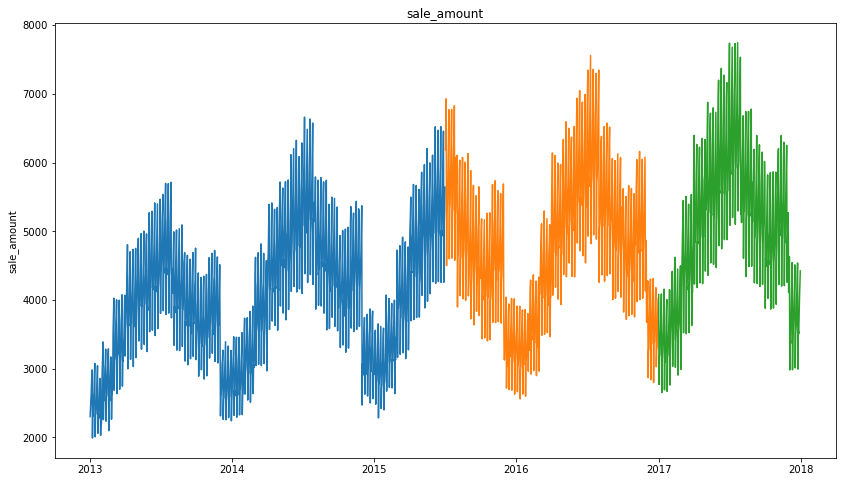

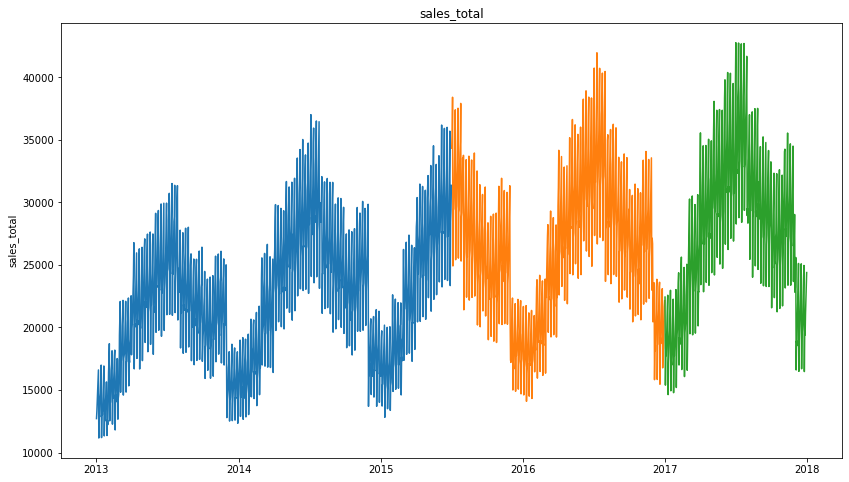

In [26]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Root Mean Squared Error to evaluate.  

In [27]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [29]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [30]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [31]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [32]:
eval_df

,model_type,target_var,rmse


## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Sales Total

In [33]:
#can use indexing to find the very last sales_total
train['sales_total'][-1:][0]

31360.52

In [34]:
# take the last item of sales total and assign to variable
last_sales = train['sales_total'][-1:][0]
last_sales

31360.52

Quantity

In [36]:
# take the last item of quantity and assign to variable
last_quantity = train['sale_amount'][-1:][0]
last_quantity

5641.0

In [42]:
yhat_df = pd.DataFrame(
    {'sales_total': [last_sales],
     'sale_amount': [last_quantity]},
    index=validate.index)

yhat_df.head()

,sales_total,sale_amount
sale_date,,
2015-07-03 00:00:00+00:00,31360.52,5641.0
2015-07-04 00:00:00+00:00,31360.52,5641.0
2015-07-05 00:00:00+00:00,31360.52,5641.0
2015-07-06 00:00:00+00:00,31360.52,5641.0
2015-07-07 00:00:00+00:00,31360.52,5641.0


In [43]:
yhat_df.describe()

,sales_total,sale_amount
count,5.480000e+02,548.0
mean,3.136052e+04,5641.0
std,3.313585e-10,0.0
min,3.136052e+04,5641.0
25%,3.136052e+04,5641.0
50%,3.136052e+04,5641.0
75%,3.136052e+04,5641.0
max,3.136052e+04,5641.0


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values.
This will plot on top of our root mean values...

sales_total -- RMSE: 7549


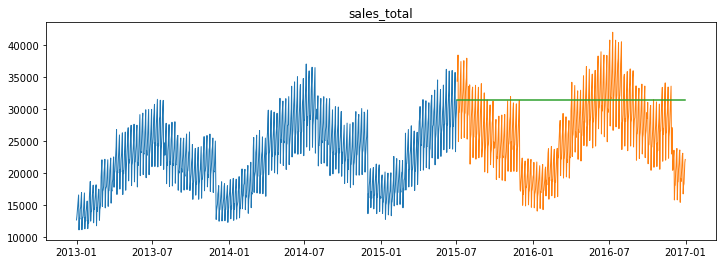

In [44]:
plot_and_eval('sales_total')

sale_amount -- RMSE: 1347


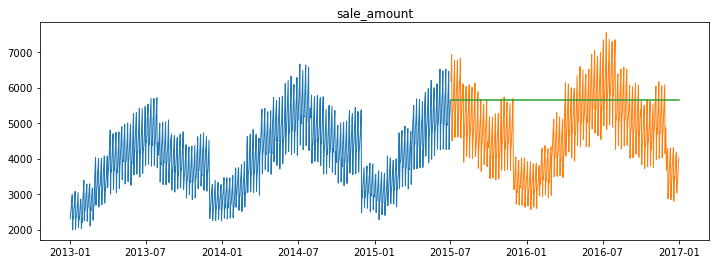

sales_total -- RMSE: 7549


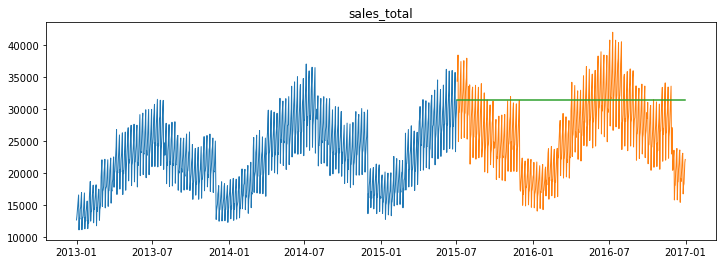

In [45]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,sale_amount,1347.0
1,last_observed_value,sales_total,7549.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

Dollars: establishing the value of the prediction we will make

In [47]:
# compute simple average
avg_sales = round(train['sales_total'].mean(), 2)
avg_sales

22472.92

Items: establishing the value of the prediction we will make

In [48]:
avg_quantity = round(train['sale_amount'].mean(), 2)
avg_quantity

4062.2

Apply predictions to our observations

In [66]:
def make_predictions(sales=None, quantity=None):
    yhat_df = pd.DataFrame({'sales_total': [sales],
                           'quantity': [quantity]},
                          index=validate.index)
    return yhat_df

In [67]:
yhat_df = make_predictions(avg_sales, avg_quantity)

In [68]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03 00:00:00+00:00,22472.92,4062.2
2015-07-04 00:00:00+00:00,22472.92,4062.2
2015-07-05 00:00:00+00:00,22472.92,4062.2
2015-07-06 00:00:00+00:00,22472.92,4062.2
2015-07-07 00:00:00+00:00,22472.92,4062.2


In [69]:
yhat_df.describe()

,sales_total,quantity
count,5.480000e+02,5.480000e+02
mean,2.247292e+04,4.062200e+03
std,6.190215e-11,2.002716e-11
min,2.247292e+04,4.062200e+03
25%,2.247292e+04,4.062200e+03
50%,2.247292e+04,4.062200e+03
75%,2.247292e+04,4.062200e+03
max,2.247292e+04,4.062200e+03


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

KeyError: 'sale_amount'

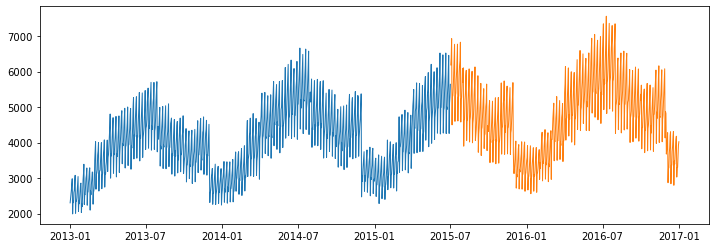

In [61]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [70]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

KeyError: 'sale_amount'

### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

In [71]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['sales_total'].rolling(30).mean())


sale_date
2013-01-01 00:00:00+00:00             NaN
2013-01-02 00:00:00+00:00             NaN
2013-01-03 00:00:00+00:00             NaN
2013-01-04 00:00:00+00:00             NaN
2013-01-05 00:00:00+00:00             NaN
                                 ...     
2015-06-28 00:00:00+00:00    29917.655333
2015-06-29 00:00:00+00:00    29677.602667
2015-06-30 00:00:00+00:00    29502.274000
2015-07-01 00:00:00+00:00    29695.175667
2015-07-02 00:00:00+00:00    29821.987333
Freq: D, Name: sales_total, Length: 913, dtype: float64


**Make Predictions**

In [72]:
period=30
train['sales_total'].rolling(period).mean()[-1]

29821.987333333338

In [73]:
period = 30 

# take 30 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
rolling_sales = round(train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['sale_amount'].rolling(period).mean()[-1], 2)
print(rolling_sales, rolling_quantity)

29821.99 5393.43


In [74]:
yhat_df = make_predictions(rolling_sales, rolling_quantity)
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03 00:00:00+00:00,29821.99,5393.43
2015-07-04 00:00:00+00:00,29821.99,5393.43
2015-07-05 00:00:00+00:00,29821.99,5393.43
2015-07-06 00:00:00+00:00,29821.99,5393.43
2015-07-07 00:00:00+00:00,29821.99,5393.43


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

KeyError: 'sale_amount'

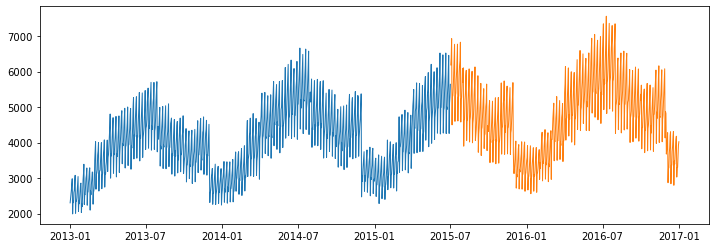

In [75]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [76]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

KeyError: 'sale_amount'

Let's try out several other values for periods:

In [77]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['sales_total'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['sale_amount'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(rolling_sales, rolling_quantity)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

KeyError: 'sale_amount'

In [ ]:
eval_df

Which is best so far? 

In [ ]:
min_items_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

In [ ]:
min_items_rmse

In [ ]:
eval_df[eval_df.rmse == min_items_rmse]

In [ ]:
min_dollars_rmse = eval_df[eval_df.target_var == 'sales_total']['rmse'].min()

eval_df[eval_df.rmse == min_dollars_rmse]

### Holt's Linear Trend


Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 



**Seasonal Decomposition**


First, let's take a look at the seasonal decomposition for each target. 

In [78]:
import statsmodels.api as sm

sale_amount 



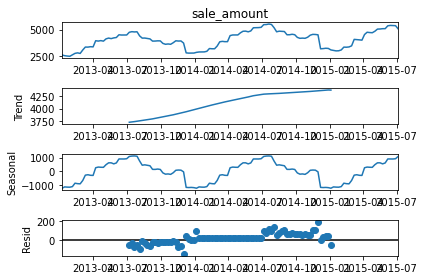

In [79]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
plt.show()

sale_amount 

sales_total 



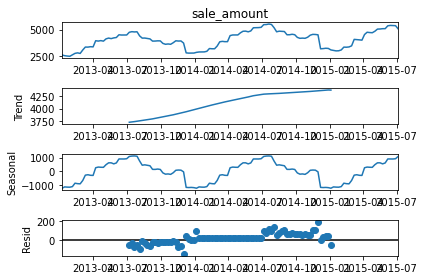

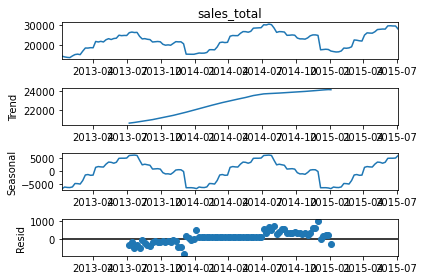

In [80]:
for col in train.columns:
    print(col,'\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)
- damped $\phi$ = True/False: with Holt, forecasts will increase or decrease indefinitely into the future.  To avoid this, use the Damped trend method which has a damping parameter 0< ϕ <1. 


fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)
- optimized: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [81]:
train.columns

Index(['sale_amount', 'sales_total'], dtype='object')

In [82]:
col = 'sales_total' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [83]:
# fit the holt's object
model = model.fit(optimized=True)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [84]:
#using model to predict (going from start of dataset [0] to end of dataset[-1])
yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [85]:
validate.shape

(548, 2)

In [86]:
yhat_items

2015-07-03 00:00:00+00:00    30056.972159
2015-07-04 00:00:00+00:00    30078.763457
2015-07-05 00:00:00+00:00    30100.336843
2015-07-06 00:00:00+00:00    30121.694494
2015-07-07 00:00:00+00:00    30142.838569
                                 ...     
2016-12-27 00:00:00+00:00    32226.808188
2016-12-28 00:00:00+00:00    32226.901126
2016-12-29 00:00:00+00:00    32226.993135
2016-12-30 00:00:00+00:00    32227.084224
2016-12-31 00:00:00+00:00    32227.174402
Freq: D, Length: 548, dtype: float64

In [87]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [88]:
yhat_df

,sales_total,quantity,sale_amount
sale_date,,,
2015-07-03 00:00:00+00:00,30056.97,5077.5,5433.57
2015-07-04 00:00:00+00:00,30078.76,5077.5,5436.81
2015-07-05 00:00:00+00:00,30100.34,5077.5,5440.01
2015-07-06 00:00:00+00:00,30121.69,5077.5,5443.17
2015-07-07 00:00:00+00:00,30142.84,5077.5,5446.31
...,...,...,...
2016-12-27 00:00:00+00:00,32226.81,5077.5,5755.47
2016-12-28 00:00:00+00:00,32226.90,5077.5,5755.48
2016-12-29 00:00:00+00:00,32226.99,5077.5,5755.49


To practice the code before putting in a loop, as above...

In [89]:
col = 'sales_total'
# create the Holt object 
model = Holt(train[col], exponential=False, damped=True)
# fit the model 
model = model.fit(optimized=True)
# make predictions for each date in validate 
yhat_items = model.predict(start = validate.index[0],
                           end = validate.index[-1])
# add predictions to yhat_df
yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [90]:
yhat_df

,sales_total,quantity,sale_amount
sale_date,,,
2015-07-03 00:00:00+00:00,30056.97,5077.5,5433.57
2015-07-04 00:00:00+00:00,30078.76,5077.5,5436.81
2015-07-05 00:00:00+00:00,30100.34,5077.5,5440.01
2015-07-06 00:00:00+00:00,30121.69,5077.5,5443.17
2015-07-07 00:00:00+00:00,30142.84,5077.5,5446.31
...,...,...,...
2016-12-27 00:00:00+00:00,32226.81,5077.5,5755.47
2016-12-28 00:00:00+00:00,32226.90,5077.5,5755.48
2016-12-29 00:00:00+00:00,32226.99,5077.5,5755.49


In [91]:
validate

,sale_amount,sales_total
sale_date,,
2015-07-03 00:00:00+00:00,6186.0,34331.90
2015-07-04 00:00:00+00:00,6394.0,35384.89
2015-07-05 00:00:00+00:00,6927.0,38402.94
2015-07-06 00:00:00+00:00,4498.0,24915.24
2015-07-07 00:00:00+00:00,5285.0,29375.84
...,...,...
2016-12-27 00:00:00+00:00,3293.0,18106.05
2016-12-28 00:00:00+00:00,3303.0,18343.25
2016-12-29 00:00:00+00:00,3609.0,19902.63


In [92]:
yhat_items

2015-07-03 00:00:00+00:00    30056.972159
2015-07-04 00:00:00+00:00    30078.763457
2015-07-05 00:00:00+00:00    30100.336843
2015-07-06 00:00:00+00:00    30121.694494
2015-07-07 00:00:00+00:00    30142.838569
                                 ...     
2016-12-27 00:00:00+00:00    32226.808188
2016-12-28 00:00:00+00:00    32226.901126
2016-12-29 00:00:00+00:00    32226.993135
2016-12-30 00:00:00+00:00    32227.084224
2016-12-31 00:00:00+00:00    32227.174402
Freq: D, Length: 548, dtype: float64

In [93]:
yhat_df

,sales_total,quantity,sale_amount
sale_date,,,
2015-07-03 00:00:00+00:00,30056.97,5077.5,5433.57
2015-07-04 00:00:00+00:00,30078.76,5077.5,5436.81
2015-07-05 00:00:00+00:00,30100.34,5077.5,5440.01
2015-07-06 00:00:00+00:00,30121.69,5077.5,5443.17
2015-07-07 00:00:00+00:00,30142.84,5077.5,5446.31
...,...,...,...
2016-12-27 00:00:00+00:00,32226.81,5077.5,5755.47
2016-12-28 00:00:00+00:00,32226.90,5077.5,5755.48
2016-12-29 00:00:00+00:00,32226.99,5077.5,5755.49


**Plot Actual vs. Predicted Values**

sale_amount -- RMSE: 1391


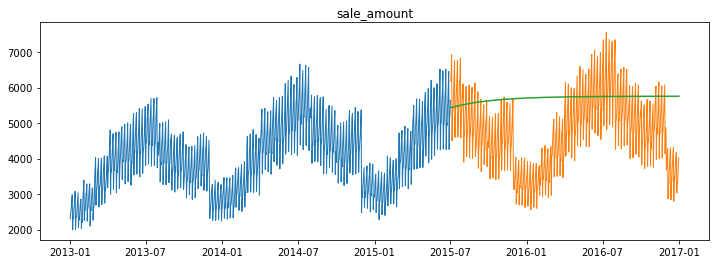

sales_total -- RMSE: 7915


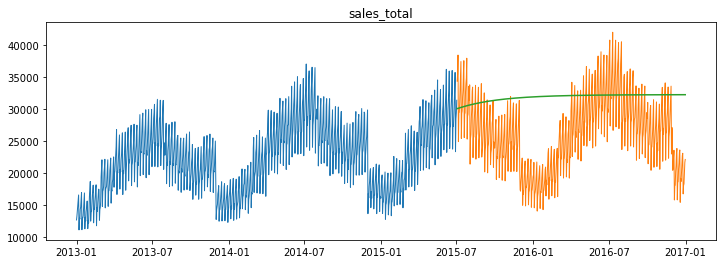

In [94]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [95]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [96]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,sale_amount,1347.0
2,holts_optimized,sale_amount,1391.0
1,last_observed_value,sales_total,7549.0
3,holts_optimized,sales_total,7915.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [97]:
#breaking this down into year breaks (training with a bit more) since data is seasonality...
train = df_resampled[:'2015']
validate = df_resampled['2016']
test = df_resampled['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1095, 2)
(366, 2)
(365, 2)


,sale_amount,sales_total
sale_date,,
2015-12-27 00:00:00+00:00,4016.0,22146.43
2015-12-28 00:00:00+00:00,2628.0,14692.21
2015-12-29 00:00:00+00:00,3087.0,17195.96
2015-12-30 00:00:00+00:00,3154.0,17479.76
2015-12-31 00:00:00+00:00,3329.0,18429.05


**Make Predictions**

In [98]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2015'] + train.diff(365).mean()

In [99]:
#what data has gone up? Quantity (sale_amount) is 374 and sales total is $2074 more
train.diff(365).mean()

sale_amount     374.564384
sales_total    2074.165699
dtype: float64

Back to predictions

In [100]:
train.loc['2015'].head()

,sale_amount,sales_total
sale_date,,
2015-01-01 00:00:00+00:00,2915.0,16106.06
2015-01-02 00:00:00+00:00,3260.0,18108.59
2015-01-03 00:00:00+00:00,3478.0,19216.32
2015-01-04 00:00:00+00:00,3559.0,19730.48
2015-01-05 00:00:00+00:00,2482.0,13719.06


In [101]:
yhat_df.head()

,sale_amount,sales_total
sale_date,,
2015-01-01 00:00:00+00:00,3289.564384,18180.225699
2015-01-02 00:00:00+00:00,3634.564384,20182.755699
2015-01-03 00:00:00+00:00,3852.564384,21290.485699
2015-01-04 00:00:00+00:00,3933.564384,21804.645699
2015-01-05 00:00:00+00:00,2856.564384,15793.225699


In [102]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

,sale_amount,sales_total
sale_date,,
2015-01-01 00:00:00+00:00,3289.564384,18180.225699
2016-01-01 00:00:00+00:00,3489.000000,19420.490000


In [103]:
# set yhat_df to index of validate
yhat_df.index = validate.index

ValueError: Length mismatch: Expected axis has 365 elements, new values have 366 elements

...Why the extra day??

In [104]:
yhat_df.shape

(365, 2)

In [105]:
validate.shape # A leap year!

(366, 2)

In [106]:
#let's drop the leap year day...
validate = validate[validate.index != '2016-02-29']

In [107]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [108]:
yhat_df.describe()

,sale_amount,sales_total
count,365.000000,365.000000
mean,4848.556164,26828.852685
std,1000.474037,5534.814227
min,2656.564384,14894.895699
25%,4059.564384,22379.065699
50%,4853.564384,26944.785699
75%,5635.564384,31117.835699
max,7301.564384,40477.105699


In [109]:
yhat_df.head()

,sale_amount,sales_total
sale_date,,
2016-01-01 00:00:00+00:00,3289.564384,18180.225699
2016-01-02 00:00:00+00:00,3634.564384,20182.755699
2016-01-03 00:00:00+00:00,3852.564384,21290.485699
2016-01-04 00:00:00+00:00,3933.564384,21804.645699
2016-01-05 00:00:00+00:00,2856.564384,15793.225699


In [110]:
yhat_df.shape

(365, 2)

**Plot and Evaluate**

sale_amount -- RMSE: 891


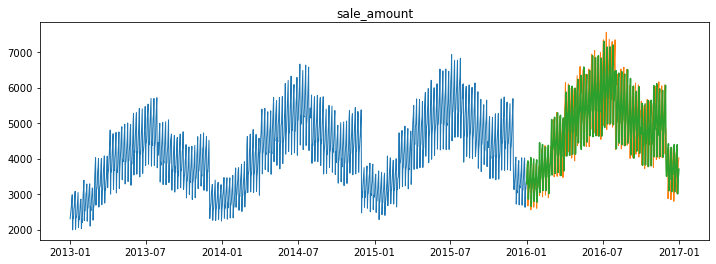

sales_total -- RMSE: 4925


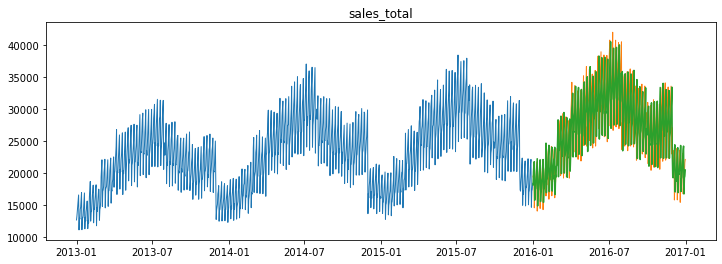

In [111]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

## Conclusion

Which model did the best? 

In [112]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

,model_type,target_var,rmse
4,previous_year,sale_amount,891.0
5,previous_year,sales_total,4925.0


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [113]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [114]:
yhat_df

,sale_amount,sales_total
sale_date,,
2017-01-01 00:00:00+00:00,3863.564384,21494.655699
2017-01-02 00:00:00+00:00,3953.564384,21803.295699
2017-01-03 00:00:00+00:00,4286.564384,23751.135699
2017-01-04 00:00:00+00:00,3038.564384,16679.435699
2017-01-05 00:00:00+00:00,3382.564384,18805.325699
...,...,...
2017-12-27 00:00:00+00:00,3667.564384,20180.215699
2017-12-28 00:00:00+00:00,3677.564384,20417.415699
2017-12-29 00:00:00+00:00,3983.564384,21976.795699


In [115]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [116]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['sale_amount'], 
                                       yhat_df['sale_amount']))

In [117]:
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)

rmse-sales total:  4751.693608320481
rmse-quantity:  859.8671537826355


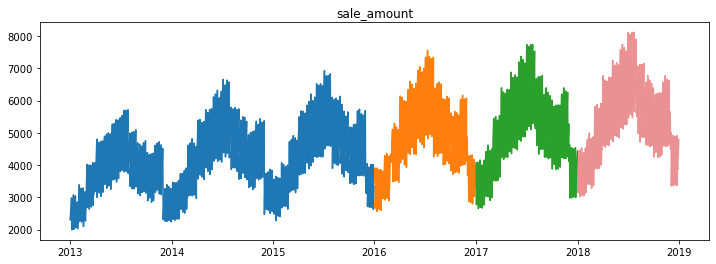

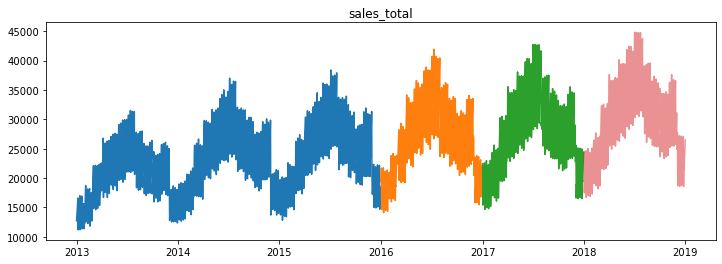

In [119]:
for col in train.columns:
    final_plot(col)

In [122]:
# to predict 2018 (take originial index (2017) and add a year on it)

yhat_df = test + train.diff(365).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [123]:
yhat_df.head()

,sale_amount,sales_total
sale_date,,
2018-01-01 05:49:12+00:00,4451.564384,24505.625699
2018-01-02 05:49:12+00:00,3145.564384,17467.075699
2018-01-03 05:49:12+00:00,3550.564384,19705.745699
2018-01-04 05:49:12+00:00,3575.564384,19776.885699
2018-01-05 05:49:12+00:00,3842.564384,21153.305699


In [124]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

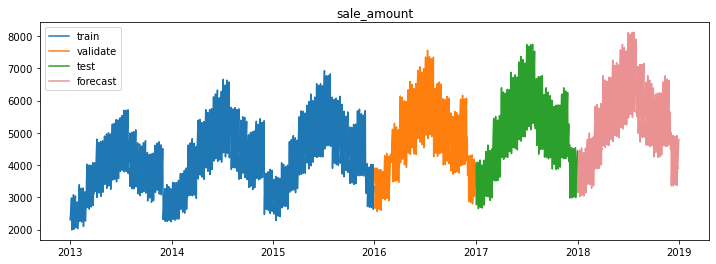

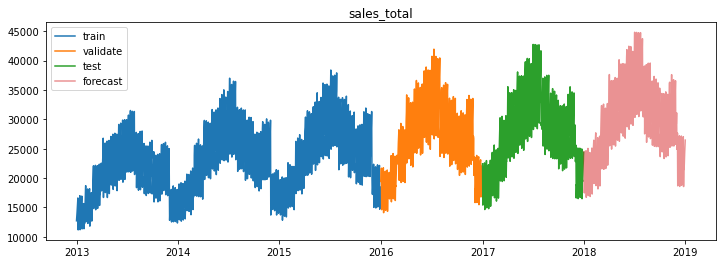

In [125]:
for col in train.columns:
    final_plot(col)

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.